## Imports

In [3]:
import copy
import bisect
import math
import numpy as np
import pickle
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
import warnings
import csv
import scipy
from scipy.optimize import fsolve
import random
from collections import defaultdict
import scipy.stats as stats
import scipy.signal
import time
import cProfile
import json
from Bio.PDB import *
import os
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from Bio import BiopythonDeprecationWarning
from Bio.PDB import PDBParser
from Bio.SeqUtils import seq3
from Bio.PDB.Polypeptide import *
import sys
sys.path.append("../referenceData/miscFunctions")
#import sphereFunctions #from: https://github.com/gjoni/trDesign/blob/master/01-hallucinate/src/utils.py
#import protein #from: https://github.com/sokrypton/ColabDesign/blob/main/colabdesign/shared/protein.py


## Global Variables and Geometric Functions

In [4]:
#Number of bins to partition theta, phi, and R. Note: 0<=R<=Rmax, 0<=theta<2pi, 0<=phi<pi
N_theta=10
N_phi=5
N_R=5

R_max=15
epsilon=.01*R_max #subtract from R_max for assignment
window=5 #discount neighbors within this quantity of index

r_intervals=np.zeros((N_R+1,))
phi_intervals=np.zeros((N_phi+1,))
theta_intervals=np.zeros((N_theta+1,))

V=4*(np.pi/3)*R_max**3

#Look at notes to see where these equations came from 
for i in range(N_R+1):
    r_intervals[i]=((V/N_R)*(3/(4*np.pi))*i)**(1/3)
print(r_intervals)
for i in range(N_theta+1):
    theta_intervals[i]=2*np.pi*i/N_theta
print(theta_intervals)
for i in range(N_phi+1):
    phi_intervals[i]=np.arccos(1-2*i/N_phi)
print(phi_intervals)

[ 0.          8.77205321 11.0520945  12.65148998 13.9247665  15.        ]
[0.         0.62831853 1.25663706 1.88495559 2.51327412 3.14159265
 3.76991118 4.39822972 5.02654825 5.65486678 6.28318531]
[0.         0.92729522 1.36943841 1.77215425 2.21429744 3.14159265]


In [5]:
#uses binary search to figure out where to place the r,theta,phi in the tuple
#returns indices s.t. it's the left of the left and right values that the number fits between
def determineBin(tup):
    binTup= (bisect.bisect_left(r_intervals,tup[0])-1,bisect.bisect_left(theta_intervals,tup[1])-1,bisect.bisect_left(phi_intervals,tup[2])-1)
    return (max(binTup[0],0), max(binTup[1],0), max(binTup[2],0))

#rotation matrices!
def rotMtxX(angle):
    return np.array([[1, 0, 0], [0, np.cos(angle), -np.sin(angle)], [0, np.sin(angle), np.cos(angle)]])
def rotMtxY(angle):
    return np.array([[np.cos(angle), 0, np.sin(angle)], [0, 1, 0], [-np.sin(angle), 0, np.cos(angle)]])
def rotMtxZ(angle):
    return np.array([[np.cos(angle), -np.sin(angle), 0], [np.sin(angle), np.cos(angle), 0], [0, 0, 1]])

#redefining geometric system. returns a rotation matrix that can be applied to a singular point
#C_alpha is origin
#positive Z axis is vector between C_alpha to C_beta,
#N lies on XZ Plane s.t. X is positive
def redefineGeoSystem(C_alpha,C_beta,N):
    C_beta=C_beta-C_alpha
    N=N-C_alpha
    
    angleToXZPlane=np.arctan2(C_beta[1],C_beta[2])
    rotMtx1=rotMtxX(angleToXZPlane)
    
    C_beta=rotMtx1@C_beta
    N=rotMtx1@N
    
    angleToZ=np.arctan2(-C_beta[0],C_beta[2])
    rotMtx2=rotMtxY(angleToZ)
    
    C_beta=rotMtx2@C_beta
    N=rotMtx2@N
    
    angleToXZPlane=np.arctan(-N[1]/N[0])
    angleToXZPlane_alt=np.pi+angleToXZPlane
    
    case=(N[0]*np.cos(angleToXZPlane)-N[1]*np.sin(angleToXZPlane))>0
    
    if case!=True:
        angleToXZPlane=angleToXZPlane_alt
    rotMtx3=rotMtxZ(angleToXZPlane)
    
    return rotMtx3@(rotMtx2@rotMtx1)

#returns r,theta,phi that defines spherical coordinates for cartesian point
# Note: 0<=R<=Rmax, 0<=theta<2pi, 0<=phi<pi
def cartesianToSpherical(point):
    r=np.sqrt(np.sum(np.square(point)))
    theta=np.arctan2(point[1],point[0])
    phi=np.arccos(point[2]/r)
    theta = theta + 2 * np.pi * (np.sign(theta) == -1)
    return (r,theta,phi)

### Variables and Functions for Secondary Structure Assignment

In [4]:
# THIS IS NEW CLASSIFICATION SYSTEM; SEE 7.17 slides
def classifySecondaryStructure(phi,psi):
    if (-1.47 <= psi) & (psi <= 0.63) & (-2.51 <= phi) & (phi <= -0.42):
        return 'R'
    elif (-0.84 <= psi) & (psi <= 1.26) & (0.63 <= phi) & (phi <= 2.51):
        return 'L'
    elif ((0.63 <= psi) & (psi <= 3.14) & (-np.pi <= phi) & (phi <= -0.42)) or ((-np.pi <= psi) & (psi <= -2.09) & (-np.pi <= phi) & (phi <= -0.84)):
        return 'B'
    return 'X'
        
print(classifySecondaryStructure(1.05,.5))

L


## functions for neighborhood determination

In [5]:
#for a list x, returns mtx s.t. mtx[i,j] is pairwise distance of x[i] and x[j]
def pw(x):
    '''compute pairwise distance'''
    x_norm = np.square(x).sum(-1)
    xx = np.einsum("...ia,...ja->...ij",x,x)
    sq_dist = x_norm[...,:,None] + x_norm[...,None,:] - 2 * xx
    return np.sqrt(sq_dist+ 1e-10)

def calc_phi_psi(prev_residue, residue, next_residue):
    try:
        C_prev = prev_residue["C"].get_vector()
        
        N = residue["N"].get_vector()
        CA = residue["CA"].get_vector()
        C = residue["C"].get_vector()
        
        N_next = next_residue["N"].get_vector()
        
        phi = calc_dihedral(C_prev, N, CA, C)
        psi = calc_dihedral(N, CA, C, N_next)
        
        return phi, psi 
    except KeyError:
        # Not all residues have all atoms, catch exceptions here
        return 'X','X'
    

#for a protein, returns all CA, CB. -1 if doesn't exist (e.g. Gly)
def getAllPositions(prot1): 
    allCoordCA=[]
    allCoordCB=[]
    allCoordN=[]
    allSecondaryStruct=[]
    fileName='../referenceData/proteinDB/pdb/' + prot1
    p = PDBParser()
    structure = p.get_structure("my_protein", fileName)
    
    for model in structure:
        for chain in model:
            residues=list(chain)
            for i in range(len(residues)):
                residue=residues[i]
                phi='X'
                psi='X'
                if residue.get_resname()!='GLY':
                    try: 
                        allCoordCA.append(np.array(residue['CA'].get_coord()))
                        allCoordCB.append(np.array(residue['CB'].get_coord()))
                        allCoordN.append(np.array(residue['N'].get_coord()))
                    except KeyError:
                        allCoordCA.append('X')
                        allCoordCB.append('X')
                        allCoordN.append('X')
                else:
                    try:
                        allCoordCA.append(np.array(residue['CA'].get_coord()))
                        #copy pasted from: https://github.com/gjoni/trDesign/blob/master/01-hallucinate/src/utils.py
                        #didn't copy function bc idk what was happening there
                        Ca=residue['CA'].get_coord()
                        N=residue['N'].get_coord()
                        C=residue['C'].get_coord()
                        b = Ca - N
                        c = C - Ca
                        a = np.cross(b, c)
                        Cb = -0.58273431*a + 0.56802827*b - 0.54067466*c + Ca
                        allCoordCB.append(np.array(Cb))
                        allCoordN.append(np.array(residue['N'].get_coord()))
                    except KeyError:
                        allCoordCA.append('X')
                        allCoordCB.append('X')
                        allCoordN.append('X')
                if i==0 or i==len(residues)-1:
                    allSecondaryStruct.append('X')
                else:
                    phi, psi = calc_phi_psi(residues[i - 1], residues[i], residues[i + 1])
                    allSecondaryStruct.append(classifySecondaryStructure(phi,psi))
    return allCoordCA, allCoordCB, allCoordN, allSecondaryStruct

#neighborMtx[i,j] 1 if i,j are neighbors, and abs(i-j)>distThreshold.
def closestNeighbors(allCoordCA,distThreshold,adjThreshold):
    dists=pw(allCoordCA)
    neighborMtx = np.where(dists < distThreshold, 1, 0)
    
    for i in range(len(neighborMtx)):
        neighborMtx[i,max(i-adjThreshold,0):(min(i+adjThreshold+1,len(neighborMtx)))]=0
        
    return dists,neighborMtx

#returns list, where each index i is a list of the bins of all the neighbors of amino acid i
def allBinsNeighborsPerProt(prot1):
    allBinsList=[]
    allCoordCA,allCoordCB,allCoordN,allSecondaryStruct=getAllPositions(prot1)
    dists,neighborMtx=closestNeighbors(allCoordCA,R_max-epsilon,window)
    numOfAA=len(dists)
    
    for aa in range(numOfAA):
        neighborBinList=[]
        curNeighborList=neighborMtx[aa,:]
        neighbors=np.where(curNeighborList==1)
        
        C_alpha=allCoordCA[aa]
        C_beta=allCoordCB[aa]
        N=allCoordN[aa]
        rotMtxForAA=redefineGeoSystem(C_alpha,C_beta,N)
        
        for j in neighbors[0]:
            #point needs to be in coord system s.t. C_alpha is origin
            point=allCoordCA[j]-C_alpha
            pointAdjusted=rotMtxForAA@point
            sphericalCoord=cartesianToSpherical(pointAdjusted)
            sphericalBins=determineBin(sphericalCoord)
            binTuple=(j,allSecondaryStruct[j],)+sphericalBins
            neighborBinList.append(binTuple)
        allBinsList.append(neighborBinList)
    return allBinsList
    

# compiling data for all proteins

In [1]:
#get all Dali Prots
with open ('../referenceData/JeanneData/dicti_train_test','rb') as file:
    dict_train_test=pickle.load(file)
allProts=list(dict_train_test.keys())

NameError: name 'pickle' is not defined

In [7]:
allProtsBinNeighbors={}
count=0
for prot in allProts:
    count+=1
    allProtsBinNeighbors[prot]=allBinsNeighborsPerProt(prot)
    if count%1000==1:
        print(int(count/1000))

0
1
2
3
4
5
6
7
8
9


/tmp/ipykernel_113096/3493170376.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  angleToXZPlane=np.arctan(-N[1]/N[0])


10
11


# functions for BLOSUM (Using TM)

In [11]:
# functions that do cigar alignment, but now using a list of indices
def parse_cigar(cigar):
    number = ''
    result = []
    for char in cigar:
        if char.isdigit():
            number += char
        else:
            result.append((char, int(number)))
            number = ''
    return result

def cig_visualizer(start1,start2,cig):
    cig_relevant=parse_cigar(cig)
    index1=start1
    index2=start2
    list1=[]
    list2=[]
    for i in cig_relevant:
        letter=i[0]
        num=i[1]
        if letter=='M':
            list1.extend(np.arange(index1-1,index1+num-1))
            list2.extend(np.arange(index2-1,index2+num-1))
            index1+=num
            index2+=num
        elif letter=='D':
            for j in range(num):
                list1.extend('-')
            list2.extend(np.arange(index2-1,index2+num-1))
            index2+=num
        elif letter=='I':
            for k in range(num):
                list2.extend('-')
            list1.extend(np.arange(index1-1,index1+num-1))
            index1+=num
    return (list1,list2)
#Creates a list of two equal length strings that align corresponding amino acids of two proteins
#based on cigar
def tmAlign_visualizer(tmArr):
    list1=[]
    list2=[]
    ind1=0
    ind2=0
    for indexProtA,i in enumerate(tmArr):
        if i==-1:
            list2.append('-')
            list1.append(indexProtA)
        elif len(list1)==0:
            list1.append(indexProtA)
            list2.append(i)
        elif len(list1)>=0:
            if list2[-1]!='-' and list2[-1]+1!=i:
                for b in range(list2[-1]+1,i):
                    list2.append(b)
                    list1.append('-')
                list2.append(i)
                list1.append(indexProtA)
            else:
                list1.append(indexProtA)
                list2.append(i)
    return (list1,list2)

#like tmAlign_visualizer but specific to the sequence IDs of amino acids
def alignPairTM(tmArr,seq1,seq2):
    list1,list2=tmAlign_visualizer(tmArr)
    res1=[]
    res2=[]
    for a in range(len(list1)):
        if list1[a]!='-':
            res1.append(seq1[list1[a]])
        elif list1[a]=='-':
            res1.append('-')
        if list2[a]!='-':
            res2.append(seq2[list2[a]])
        elif list2[a]=='-':
            res2.append('-')
    return (res1,res2)
            
    
def getIndex(l,value):
    try: 
        return l.index(value)
    except: 
        return -1
    
def neighborMtxMaker(start1,start2,cig,neighborList1,neighborList2):
    templist1,templist2=cig_visualizer(start1,start2,cig)
    list1=[]
    list2=[]
    for i in range(len(templist1)):
        if templist1[i]!='-' and templist2[i]!='-':
            list1.append(templist1[i])
            list2.append(templist2[i])
    dim=len(list1)
    neighborMtx1=[[0 for _ in range(dim)] for _ in range(dim)]
    neighborMtx2=[[0 for _ in range(dim)] for _ in range(dim)]
    for i in range(len(list1)):
        curIndex1=list1[i]
        curIndex2=list2[i]
        rowOfInterest1=neighborList1[curIndex1]
        rowOfInterest2=neighborList2[curIndex2]
        for j in rowOfInterest1:
            neighborId=j[0]
            binTup=j[1:]
            indexOfNeighborInAdjustedCigarString=getIndex(list1,neighborId)
            if indexOfNeighborInAdjustedCigarString!=-1:
                neighborMtx1[i][indexOfNeighborInAdjustedCigarString]=binTup
        for j in rowOfInterest2:
            neighborId=j[0]
            binTup=j[1:]
            indexOfNeighborInAdjustedCigarString=getIndex(list2,neighborId)
            if indexOfNeighborInAdjustedCigarString!=-1:
                neighborMtx2[i][indexOfNeighborInAdjustedCigarString]=binTup
    return neighborMtx1,neighborMtx2


def neighborMtxMakerTM(tmAlgt,neighborList1,neighborList2):
    templist1,templist2=tmAlign_visualizer(tmAlgt)
    list1=[]
    list2=[]
    for i in range(len(templist1)):
        if templist1[i]!='-' and templist2[i]!='-':
            list1.append(templist1[i])
            list2.append(templist2[i])
    dim=len(list1)
    neighborMtx1=[[0 for _ in range(dim)] for _ in range(dim)]
    neighborMtx2=[[0 for _ in range(dim)] for _ in range(dim)]
    for i in range(len(list1)):
        curIndex1=list1[i]
        curIndex2=list2[i]
        rowOfInterest1=neighborList1[curIndex1]
        rowOfInterest2=neighborList2[curIndex2]
        for j in rowOfInterest1:
            neighborId=j[0]
            binTup=j[1:]
            indexOfNeighborInAdjustedCigarString=getIndex(list1,neighborId)
            if indexOfNeighborInAdjustedCigarString!=-1:
                neighborMtx1[i][indexOfNeighborInAdjustedCigarString]=binTup
        for j in rowOfInterest2:
            neighborId=j[0]
            binTup=j[1:]
            indexOfNeighborInAdjustedCigarString=getIndex(list2,neighborId)
            if indexOfNeighborInAdjustedCigarString!=-1:
                neighborMtx2[i][indexOfNeighborInAdjustedCigarString]=binTup
    return neighborMtx1,neighborMtx2


def preprocessFileTM(file,parserDict):
    fileInfo=parseFile_TM(file)
    dataList=[]  
    for key in fileInfo:
        seq1=parserDict[key[0]]
        seq2=parserDict[key[1]]
        tmArr=fileInfo[key]
        dataList.append(alignPairTM(tmArr,seq1,seq2))
    return dataList
        
#parseFile but using TM align
#returns dict: dic[pair]=TM-alignment
def parseFile_TM(fileName):
    fileInfo={}
    with open (fileName,'r') as file:
        reader=csv.reader(file,delimiter=',')
        next(reader)
        for i,row in enumerate(reader):
            try:
                algt_str=row[4]
                algt_str=algt_str.strip('[]')
                algt_str=algt_str.split()
                #algt=list(map(int, algt_str))
                algt=[int(s) for s in algt_str]
                fileInfo[(row[1],row[2])]=algt
            except ValueError:
                print(i)
                print(row)
    return fileInfo
    
def tmAlign_visualizer(tmArr):
    list1=[]
    list2=[]
    ind1=0
    ind2=0
    for indexProtA,i in enumerate(tmArr):
        if i==-1:
            list2.append('-')
            list1.append(indexProtA)
        elif len(list1)==0:
            list1.append(indexProtA)
            list2.append(i)
        elif len(list1)>=0:
            if list2[-1]!='-' and list2[-1]+1!=i:
                for b in range(list2[-1]+1,i):
                    list2.append(b)
                    list1.append('-')
                list2.append(i)
                list1.append(indexProtA)
            else:
                list1.append(indexProtA)
                list2.append(i)
    return (list1,list2)

# Frequency Counts for Aligned Bins

In [5]:
allBins=[]
for a in ['B','L','R','X']:
    for i in range(N_R):
        for j in range(N_theta):
            for k in range(N_phi):
                allBins.append((a,i,j,k))
print(len(allBins))

1000


In [8]:
#reading in relevant files: family!
file='../referenceData/dataSplit/pairs_training.csv'
fileInfo=parseFile_TM(file)

133155
['e.29', 'd1twfb_', 'd1smyc_', '0.71044', '[-1 -1 -1 ... -1 -1 -1]']
133156
['e.29', 'd1smyc_', 'd1twfb_', '0.69544', '[-1 -1 -1 ... -1 -1 -1]']


In [13]:

blosumSingleCounts={}
blosumPairCounts={}
totalCount=0
for i in allBins:
    blosumSingleCounts[i]=0
    for j in allBins:
        key=frozenset([i,j])
        blosumPairCounts[key]=0
    blosumPairCounts[frozenset([i,-1])]=0# this corresponds to off the map
blosumSingleCounts[-1]=0 



tCount=1
for key in fileInfo:
    prot1,prot2=key
    tmAlgnmt=fileInfo[key]
    list1,list2=tmAlign_visualizer(tmAlgnmt)
    sphereInfo1=allProtsBinNeighbors[prot1]
    sphereInfo2=allProtsBinNeighbors[prot2]

    resMtx1,resMtx2=neighborMtxMakerTM(tmAlgnmt,sphereInfo1,sphereInfo2)
    dim=len(resMtx1)
    for i in range(dim):
        for j in range(dim):
            binVal1=resMtx1[i][j]
            binVal2=resMtx2[i][j]
            if binVal1!=0 and binVal2!=0:
                binVal1=resMtx1[i][j]
                binVal2=resMtx2[i][j]
                pair=frozenset([binVal1,binVal2])
                blosumPairCounts[pair]+=1
                blosumSingleCounts[binVal1]+=1
                blosumSingleCounts[binVal2]+=1
                totalCount+=1
            elif binVal1!=0 and binVal2==0:
                pair=frozenset([binVal1,-1])
                blosumPairCounts[pair]+=1
                blosumSingleCounts[binVal1]+=1
                blosumSingleCounts[-1]+=1
                totalCount+=1
            elif binVal1==0 and binVal2!=0:
                pair=frozenset([binVal2,-1])
                blosumPairCounts[pair]+=1
                blosumSingleCounts[binVal2]+=1
                blosumSingleCounts[-1]+=1
                totalCount+=1
                
    
    if tCount%10==0:
        print(tCount/10)
    tCount+=1
    totalCountSingle=totalCount*2
    totalCountPairs=totalCount

for key in blosumSingleCounts.keys():
    blosumSingleCounts[key]=blosumSingleCounts[key]/totalCountSingle
for key in blosumPairCounts.keys():
    blosumPairCounts[key]=blosumPairCounts[key]/totalCountPairs
                        m

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
101.0
102.0
103.0
104.0
105.0
106.0
107.0
108.0
109.0
110.0
111.0
112.0
113.0
114.0
115.0
116.0
117.0
118.0
119.0
120.0
121.0
122.0
123.0
124.0
125.0
126.0
127.0
128.0
129.0
130.0
131.0
132.0
133.0
134.0
135.0
136.0
137.0
138.0
139.0
140.0
141.0
142.0
143.0
144.0
145.0
146.0
147.0
148.0
149.0
150.0
151.0
152.0
153.0
154.0
155.0
156.0
157.0
158.0
159.0
160.0
161.0
162.0
163.0
164.0
165.0
166.0
167.0
168.0
169.0
170.0
171.0
172.0
173.0
174.0
175.0
176.0
177.0
178.0
179.0
180.0
181.0
182.0
183.0
184.0
185.

2050.0
2051.0
2052.0
2053.0
2054.0
2055.0
2056.0
2057.0
2058.0
2059.0
2060.0
2061.0
2062.0
2063.0
2064.0
2065.0
2066.0
2067.0
2068.0
2069.0
2070.0
2071.0
2072.0
2073.0
2074.0
2075.0
2076.0
2077.0
2078.0
2079.0
2080.0
2081.0
2082.0
2083.0
2084.0
2085.0
2086.0
2087.0
2088.0
2089.0
2090.0
2091.0
2092.0
2093.0
2094.0
2095.0
2096.0
2097.0
2098.0
2099.0
2100.0
2101.0
2102.0
2103.0
2104.0
2105.0
2106.0
2107.0
2108.0
2109.0
2110.0
2111.0
2112.0
2113.0
2114.0
2115.0
2116.0
2117.0
2118.0
2119.0
2120.0
2121.0
2122.0
2123.0
2124.0
2125.0
2126.0
2127.0
2128.0
2129.0
2130.0
2131.0
2132.0
2133.0
2134.0
2135.0
2136.0
2137.0
2138.0
2139.0
2140.0
2141.0
2142.0
2143.0
2144.0
2145.0
2146.0
2147.0
2148.0
2149.0
2150.0
2151.0
2152.0
2153.0
2154.0
2155.0
2156.0
2157.0
2158.0
2159.0
2160.0
2161.0
2162.0
2163.0
2164.0
2165.0
2166.0
2167.0
2168.0
2169.0
2170.0
2171.0
2172.0
2173.0
2174.0
2175.0
2176.0
2177.0
2178.0
2179.0
2180.0
2181.0
2182.0
2183.0
2184.0
2185.0
2186.0
2187.0
2188.0
2189.0
2190.0
2191.0
2192.0

3222.0
3223.0
3224.0
3225.0
3226.0
3227.0
3228.0
3229.0
3230.0
3231.0
3232.0
3233.0
3234.0
3235.0
3236.0
3237.0
3238.0
3239.0
3240.0
3241.0
3242.0
3243.0
3244.0
3245.0
3246.0
3247.0
3248.0
3249.0
3250.0
3251.0
3252.0
3253.0
3254.0
3255.0
3256.0
3257.0
3258.0
3259.0
3260.0
3261.0
3262.0
3263.0
3264.0
3265.0
3266.0
3267.0
3268.0
3269.0
3270.0
3271.0
3272.0
3273.0
3274.0
3275.0
3276.0
3277.0
3278.0
3279.0
3280.0
3281.0
3282.0
3283.0
3284.0
3285.0
3286.0
3287.0
3288.0
3289.0
3290.0
3291.0
3292.0
3293.0
3294.0
3295.0
3296.0
3297.0
3298.0
3299.0
3300.0
3301.0
3302.0
3303.0
3304.0
3305.0
3306.0
3307.0
3308.0
3309.0
3310.0
3311.0
3312.0
3313.0
3314.0
3315.0
3316.0
3317.0
3318.0
3319.0
3320.0
3321.0
3322.0
3323.0
3324.0
3325.0
3326.0
3327.0
3328.0
3329.0
3330.0
3331.0
3332.0
3333.0
3334.0
3335.0
3336.0
3337.0
3338.0
3339.0
3340.0
3341.0
3342.0
3343.0
3344.0
3345.0
3346.0
3347.0
3348.0
3349.0
3350.0
3351.0
3352.0
3353.0
3354.0
3355.0
3356.0
3357.0
3358.0
3359.0
3360.0
3361.0
3362.0
3363.0
3364.0

4393.0
4394.0
4395.0
4396.0
4397.0
4398.0
4399.0
4400.0
4401.0
4402.0
4403.0
4404.0
4405.0
4406.0
4407.0
4408.0
4409.0
4410.0
4411.0
4412.0
4413.0
4414.0
4415.0
4416.0
4417.0
4418.0
4419.0
4420.0
4421.0
4422.0
4423.0
4424.0
4425.0
4426.0
4427.0
4428.0
4429.0
4430.0
4431.0
4432.0
4433.0
4434.0
4435.0
4436.0
4437.0
4438.0
4439.0
4440.0
4441.0
4442.0
4443.0
4444.0
4445.0
4446.0
4447.0
4448.0
4449.0
4450.0
4451.0
4452.0
4453.0
4454.0
4455.0
4456.0
4457.0
4458.0
4459.0
4460.0
4461.0
4462.0
4463.0
4464.0
4465.0
4466.0
4467.0
4468.0
4469.0
4470.0
4471.0
4472.0
4473.0
4474.0
4475.0
4476.0
4477.0
4478.0
4479.0
4480.0
4481.0
4482.0
4483.0
4484.0
4485.0
4486.0
4487.0
4488.0
4489.0
4490.0
4491.0
4492.0
4493.0
4494.0
4495.0
4496.0
4497.0
4498.0
4499.0
4500.0
4501.0
4502.0
4503.0
4504.0
4505.0
4506.0
4507.0
4508.0
4509.0
4510.0
4511.0
4512.0
4513.0
4514.0
4515.0
4516.0
4517.0
4518.0
4519.0
4520.0
4521.0
4522.0
4523.0
4524.0
4525.0
4526.0
4527.0
4528.0
4529.0
4530.0
4531.0
4532.0
4533.0
4534.0
4535.0

5564.0
5565.0
5566.0
5567.0
5568.0
5569.0
5570.0
5571.0
5572.0
5573.0
5574.0
5575.0
5576.0
5577.0
5578.0
5579.0
5580.0
5581.0
5582.0
5583.0
5584.0
5585.0
5586.0
5587.0
5588.0
5589.0
5590.0
5591.0
5592.0
5593.0
5594.0
5595.0
5596.0
5597.0
5598.0
5599.0
5600.0
5601.0
5602.0
5603.0
5604.0
5605.0
5606.0
5607.0
5608.0
5609.0
5610.0
5611.0
5612.0
5613.0
5614.0
5615.0
5616.0
5617.0
5618.0
5619.0
5620.0
5621.0
5622.0
5623.0
5624.0
5625.0
5626.0
5627.0
5628.0
5629.0
5630.0
5631.0
5632.0
5633.0
5634.0
5635.0
5636.0
5637.0
5638.0
5639.0
5640.0
5641.0
5642.0
5643.0
5644.0
5645.0
5646.0
5647.0
5648.0
5649.0
5650.0
5651.0
5652.0
5653.0
5654.0
5655.0
5656.0
5657.0
5658.0
5659.0
5660.0
5661.0
5662.0
5663.0
5664.0
5665.0
5666.0
5667.0
5668.0
5669.0
5670.0
5671.0
5672.0
5673.0
5674.0
5675.0
5676.0
5677.0
5678.0
5679.0
5680.0
5681.0
5682.0
5683.0
5684.0
5685.0
5686.0
5687.0
5688.0
5689.0
5690.0
5691.0
5692.0
5693.0
5694.0
5695.0
5696.0
5697.0
5698.0
5699.0
5700.0
5701.0
5702.0
5703.0
5704.0
5705.0
5706.0

6741.0
6742.0
6743.0
6744.0
6745.0
6746.0
6747.0
6748.0
6749.0
6750.0
6751.0
6752.0
6753.0
6754.0
6755.0
6756.0
6757.0
6758.0
6759.0
6760.0
6761.0
6762.0
6763.0
6764.0
6765.0
6766.0
6767.0
6768.0
6769.0
6770.0
6771.0
6772.0
6773.0
6774.0
6775.0
6776.0
6777.0
6778.0
6779.0
6780.0
6781.0
6782.0
6783.0
6784.0
6785.0
6786.0
6787.0
6788.0
6789.0
6790.0
6791.0
6792.0
6793.0
6794.0
6795.0
6796.0
6797.0
6798.0
6799.0
6800.0
6801.0
6802.0
6803.0
6804.0
6805.0
6806.0
6807.0
6808.0
6809.0
6810.0
6811.0
6812.0
6813.0
6814.0
6815.0
6816.0
6817.0
6818.0
6819.0
6820.0
6821.0
6822.0
6823.0
6824.0
6825.0
6826.0
6827.0
6828.0
6829.0
6830.0
6831.0
6832.0
6833.0
6834.0
6835.0
6836.0
6837.0
6838.0
6839.0
6840.0
6841.0
6842.0
6843.0
6844.0
6845.0
6846.0
6847.0
6848.0
6849.0
6850.0
6851.0
6852.0
6853.0
6854.0
6855.0
6856.0
6857.0
6858.0
6859.0
6860.0
6861.0
6862.0
6863.0
6864.0
6865.0
6866.0
6867.0
6868.0
6869.0
6870.0
6871.0
6872.0
6873.0
6874.0
6875.0
6876.0
6877.0
6878.0
6879.0
6880.0
6881.0
6882.0
6883.0

7980.0
7981.0
7982.0
7983.0
7984.0
7985.0
7986.0
7987.0
7988.0
7989.0
7990.0
7991.0
7992.0
7993.0
7994.0
7995.0
7996.0
7997.0
7998.0
7999.0
8000.0
8001.0
8002.0
8003.0
8004.0
8005.0
8006.0
8007.0
8008.0
8009.0
8010.0
8011.0
8012.0
8013.0
8014.0
8015.0
8016.0
8017.0
8018.0
8019.0
8020.0
8021.0
8022.0
8023.0
8024.0
8025.0
8026.0
8027.0
8028.0
8029.0
8030.0
8031.0
8032.0
8033.0
8034.0
8035.0
8036.0
8037.0
8038.0
8039.0
8040.0
8041.0
8042.0
8043.0
8044.0
8045.0
8046.0
8047.0
8048.0
8049.0
8050.0
8051.0
8052.0
8053.0
8054.0
8055.0
8056.0
8057.0
8058.0
8059.0
8060.0
8061.0
8062.0
8063.0
8064.0
8065.0
8066.0
8067.0
8068.0
8069.0
8070.0
8071.0
8072.0
8073.0
8074.0
8075.0
8076.0
8077.0
8078.0
8079.0
8080.0
8081.0
8082.0
8083.0
8084.0
8085.0
8086.0
8087.0
8088.0
8089.0
8090.0
8091.0
8092.0
8093.0
8094.0
8095.0
8096.0
8097.0
8098.0
8099.0
8100.0
8101.0
8102.0
8103.0
8104.0
8105.0
8106.0
8107.0
8108.0
8109.0
8110.0
8111.0
8112.0
8113.0
8114.0
8115.0
8116.0
8117.0
8118.0
8119.0
8120.0
8121.0
8122.0

9301.0
9302.0
9303.0
9304.0
9305.0
9306.0
9307.0
9308.0
9309.0
9310.0
9311.0
9312.0
9313.0
9314.0
9315.0
9316.0
9317.0
9318.0
9319.0
9320.0
9321.0
9322.0
9323.0
9324.0
9325.0
9326.0
9327.0
9328.0
9329.0
9330.0
9331.0
9332.0
9333.0
9334.0
9335.0
9336.0
9337.0
9338.0
9339.0
9340.0
9341.0
9342.0
9343.0
9344.0
9345.0
9346.0
9347.0
9348.0
9349.0
9350.0
9351.0
9352.0
9353.0
9354.0
9355.0
9356.0
9357.0
9358.0
9359.0
9360.0
9361.0
9362.0
9363.0
9364.0
9365.0
9366.0
9367.0
9368.0
9369.0
9370.0
9371.0
9372.0
9373.0
9374.0
9375.0
9376.0
9377.0
9378.0
9379.0
9380.0
9381.0
9382.0
9383.0
9384.0
9385.0
9386.0
9387.0
9388.0
9389.0
9390.0
9391.0
9392.0
9393.0
9394.0
9395.0
9396.0
9397.0
9398.0
9399.0
9400.0
9401.0
9402.0
9403.0
9404.0
9405.0
9406.0
9407.0
9408.0
9409.0
9410.0
9411.0
9412.0
9413.0
9414.0
9415.0
9416.0
9417.0
9418.0
9419.0
9420.0
9421.0
9422.0
9423.0
9424.0
9425.0
9426.0
9427.0
9428.0
9429.0
9430.0
9431.0
9432.0
9433.0
9434.0
9435.0
9436.0
9437.0
9438.0
9439.0
9440.0
9441.0
9442.0
9443.0

10639.0
10640.0
10641.0
10642.0
10643.0
10644.0
10645.0
10646.0
10647.0
10648.0
10649.0
10650.0
10651.0
10652.0
10653.0
10654.0
10655.0
10656.0
10657.0
10658.0
10659.0
10660.0
10661.0
10662.0
10663.0
10664.0
10665.0
10666.0
10667.0
10668.0
10669.0
10670.0
10671.0
10672.0
10673.0
10674.0
10675.0
10676.0
10677.0
10678.0
10679.0
10680.0
10681.0
10682.0
10683.0
10684.0
10685.0
10686.0
10687.0
10688.0
10689.0
10690.0
10691.0
10692.0
10693.0
10694.0
10695.0
10696.0
10697.0
10698.0
10699.0
10700.0
10701.0
10702.0
10703.0
10704.0
10705.0
10706.0
10707.0
10708.0
10709.0
10710.0
10711.0
10712.0
10713.0
10714.0
10715.0
10716.0
10717.0
10718.0
10719.0
10720.0
10721.0
10722.0
10723.0
10724.0
10725.0
10726.0
10727.0
10728.0
10729.0
10730.0
10731.0
10732.0
10733.0
10734.0
10735.0
10736.0
10737.0
10738.0
10739.0
10740.0
10741.0
10742.0
10743.0
10744.0
10745.0
10746.0
10747.0
10748.0
10749.0
10750.0
10751.0
10752.0
10753.0
10754.0
10755.0
10756.0
10757.0
10758.0
10759.0
10760.0
10761.0
10762.0
10763.0


11664.0
11665.0
11666.0
11667.0
11668.0
11669.0
11670.0
11671.0
11672.0
11673.0
11674.0
11675.0
11676.0
11677.0
11678.0
11679.0
11680.0
11681.0
11682.0
11683.0
11684.0
11685.0
11686.0
11687.0
11688.0
11689.0
11690.0
11691.0
11692.0
11693.0
11694.0
11695.0
11696.0
11697.0
11698.0
11699.0
11700.0
11701.0
11702.0
11703.0
11704.0
11705.0
11706.0
11707.0
11708.0
11709.0
11710.0
11711.0
11712.0
11713.0
11714.0
11715.0
11716.0
11717.0
11718.0
11719.0
11720.0
11721.0
11722.0
11723.0
11724.0
11725.0
11726.0
11727.0
11728.0
11729.0
11730.0
11731.0
11732.0
11733.0
11734.0
11735.0
11736.0
11737.0
11738.0
11739.0
11740.0
11741.0
11742.0
11743.0
11744.0
11745.0
11746.0
11747.0
11748.0
11749.0
11750.0
11751.0
11752.0
11753.0
11754.0
11755.0
11756.0
11757.0
11758.0
11759.0
11760.0
11761.0
11762.0
11763.0
11764.0
11765.0
11766.0
11767.0
11768.0
11769.0
11770.0
11771.0
11772.0
11773.0
11774.0
11775.0
11776.0
11777.0
11778.0
11779.0
11780.0
11781.0
11782.0
11783.0
11784.0
11785.0
11786.0
11787.0
11788.0


12689.0
12690.0
12691.0
12692.0
12693.0
12694.0
12695.0
12696.0
12697.0
12698.0
12699.0
12700.0
12701.0
12702.0
12703.0
12704.0
12705.0
12706.0
12707.0
12708.0
12709.0
12710.0
12711.0
12712.0
12713.0
12714.0
12715.0
12716.0
12717.0
12718.0
12719.0
12720.0
12721.0
12722.0
12723.0
12724.0
12725.0
12726.0
12727.0
12728.0
12729.0
12730.0
12731.0
12732.0
12733.0
12734.0
12735.0
12736.0
12737.0
12738.0
12739.0
12740.0
12741.0
12742.0
12743.0
12744.0
12745.0
12746.0
12747.0
12748.0
12749.0
12750.0
12751.0
12752.0
12753.0
12754.0
12755.0
12756.0
12757.0
12758.0
12759.0
12760.0
12761.0
12762.0
12763.0
12764.0
12765.0
12766.0
12767.0
12768.0
12769.0
12770.0
12771.0
12772.0
12773.0
12774.0
12775.0
12776.0
12777.0
12778.0
12779.0
12780.0
12781.0
12782.0
12783.0
12784.0
12785.0
12786.0
12787.0
12788.0
12789.0
12790.0
12791.0
12792.0
12793.0
12794.0
12795.0
12796.0
12797.0
12798.0
12799.0
12800.0
12801.0
12802.0
12803.0
12804.0
12805.0
12806.0
12807.0
12808.0
12809.0
12810.0
12811.0
12812.0
12813.0


with open('../variables/infoDictionaries/sphereBlosumSingleCounts.pkl', 'wb') as f:
    pickle.dump(blosumSingleCounts, f)

with open('../variables/infoDictionaries/sphereBlosumPairCounts.pkl', 'wb') as f:
    pickle.dump(blosumPairCounts, f)

with open('../variables/infoDictionaries/allProtSphericalBinsWithSecondaryStruct.pkl','wb') as f:
    pickle.dump(allProtsBinNeighbors,f)

## Constructing Transition Matrix

In [6]:
def genTMtx(blosumSingleCounts,blosumPairCounts):
    mtxIndex=list(blosumSingleCounts.keys())
    binCt=len(mtxIndex)
    pairMtx=np.zeros((binCt,binCt))

    for i in range(binCt):
        curSum=0
        for j in range(i,binCt):
            if not (mtxIndex[i]==-1 and mtxIndex[j]==-1):
                pair=frozenset([mtxIndex[i],mtxIndex[j]])
                pairMtx[i,j]=blosumPairCounts[pair]

    totPairs=0
    for key in blosumPairCounts:
        totPairs+=blosumPairCounts[key]

    f=0.5*pairMtx+0.5*np.transpose(pairMtx)

    #i forget what this is from, prob stationary distribution to validate??
#     c=np.zeros((binCt,1))
#     for i in range(binCt):
#         c[i]=np.sum(pairMtx[i,:])+np.sum(pairMtx[:,i])

#     s=c/(2*np.sum(pairMtx))

    tMtx=np.zeros((binCt,binCt))


    for i in range(binCt):
        rowSum=np.sum(f[i,:])
        for j in range(binCt):
            tMtx[i,j]=f[i,j]/rowSum
    return tMtx


## Validating the -1 bin value

### Am doing this over all of the train proteins only

In [10]:
#get all Dali Prots
with open ('../referenceData/JeanneData/dicti_train_test','rb') as file:
    dict_train_test=pickle.load(file)
allProts=list(dict_train_test.keys())

In [11]:
trainProts=[]
for prot in allProts:
    if dict_train_test[prot]=='train':
        trainProts.append(prot)

In [12]:
print(len(trainProts))

6506


In [30]:

s=0
d=0
count=0
tMtx=genTMtx(blosumSingleCounts,blosumPairCounts)
for key in trainProts:

    currentSphere=allProtsBinNeighbors[key]
    length=len(currentSphere)
    vec=np.zeros((length,1001))
    for j in range(length):
        currentAA=currentSphere[j]
        vec[j,:]=np.array(oneHotFromListRowVec(currentAA,mtxIndex))
        
    bv1=np.einsum('ik,kj->ij', vec, tMtx)[:,:-1]
    s+=np.sum(vec)-(np.sum(bv1))
    d+=length
    
    if count%100==0:
        print(f"{count}/{len(trainProts)}")
        print(s/d)
    count+=1

0/6506
4.929371367207311
100/6506
4.506550711311754
200/6506
4.163800997139449
300/6506
4.194371684157321
400/6506
4.206561349097352
500/6506
4.110124202642736
600/6506
4.2343004277013705
700/6506
4.43496504924463
800/6506
4.4320981877976875
900/6506
4.431672634251848
1000/6506
5.027369810777033
1100/6506
5.30945267873206
1200/6506
5.371934239211857
1300/6506
5.324814373558911
1400/6506
5.299389411654882
1500/6506
5.26662944199972
1600/6506
5.2248597962772365
1700/6506
5.199694865311356
1800/6506
5.180435470696703
1900/6506
5.19551693689997
2000/6506
5.161517183943807
2100/6506
5.132519960079966
2200/6506
5.143918221837671
2300/6506
5.230035887402216
2400/6506
5.217002594695035
2500/6506
5.3039784826119964
2600/6506
5.336211523537654
2700/6506
5.315813565356405
2800/6506
5.31921032772435
2900/6506
5.369056670123745
3000/6506
5.420731766003341
3100/6506
5.478055999953756
3200/6506
5.519208851063687
3300/6506
5.551005324761938
3400/6506
5.591637774397501
3500/6506
5.616828541826672
3600/

In [32]:
print(allProtsBinNeighbors[trainProts[1000]])

[[(6, 'R', 1, 3, 1), (7, 'R', 2, 2, 1), (8, 'B', 3, 2, 2), (27, 'R', 3, 1, 2), (28, 'R', 1, 1, 2), (29, 'R', 2, 1, 2), (30, 'R', 3, 1, 2), (31, 'R', 1, 1, 2), (32, 'R', 1, 1, 3), (33, 'R', 3, 1, 3), (34, 'R', 3, 0, 3), (35, 'R', 1, 0, 3), (36, 'L', 2, 0, 4), (37, 'R', 0, 1, 4), (38, 'R', 1, 2, 4), (39, 'R', 2, 2, 4), (40, 'R', 1, 3, 4), (41, 'B', 1, 3, 4), (42, 'B', 4, 3, 4), (266, 'R', 4, 9, 1), (267, 'R', 3, 8, 1), (269, 'R', 3, 9, 0), (270, 'R', 1, 9, 0), (271, 'R', 2, 8, 0), (272, 'R', 2, 9, 0), (273, 'R', 1, 0, 0), (274, 'R', 0, 7, 0), (275, 'B', 2, 6, 0), (276, 'B', 2, 4, 0), (277, 'L', 2, 3, 0), (278, 'X', 1, 2, 0), (279, 'B', 2, 1, 0), (285, 'R', 3, 1, 0), (288, 'R', 3, 0, 1), (289, 'R', 2, 0, 1), (290, 'R', 4, 0, 1), (291, 'R', 4, 0, 1), (292, 'R', 2, 0, 1), (293, 'R', 2, 0, 2), (295, 'R', 4, 9, 2), (296, 'R', 2, 9, 2)], [(7, 'R', 1, 4, 4), (8, 'B', 2, 4, 4), (24, 'R', 4, 5, 4), (25, 'R', 3, 5, 4), (26, 'R', 4, 5, 4), (27, 'R', 3, 6, 4), (28, 'R', 1, 6, 4), (29, 'R', 1, 6, 4),

## Creating 1Hot version of allProtSphericalBinsWithSecondaryStruct.pkl

In [10]:
def getIndex(l,value):
    try: 
        return l.index(value)
    except: 
        return 'e'
    
    
def oneHotFromList(l,mtxIndex):
    binCt=len(mtxIndex)
    oneHot=np.zeros((1,binCt))
    dim=len(l)
    for j in range(dim):
        binVal=l[j][1:]
        ind1=getIndex(mtxIndex,binVal)
        oneHot[0][ind1]+=1
    return oneHot

def oneHotFromListRowVec(l,mtxIndex):
    binCt=len(mtxIndex)
    oneHot=np.zeros((binCt))
    dim=len(l)
    for j in range(dim):
        binVal=l[j][1:]
        ind1=getIndex(mtxIndex,binVal)
        oneHot[ind1]+=1
    return oneHot

with open('../variables/infoDictionaries/sphereSingleCounts.pkl','rb') as f:
    blosumSingleCounts=pickle.load(f)

    
mtxIndex=list(blosumSingleCounts.keys())
binCt=len(mtxIndex)
print(binCt)
print(mtxIndex)

    
    

FileNotFoundError: [Errno 2] No such file or directory: '../variables/infoDictionaries/sphereSingleCounts.pkl'

In [35]:
allProtsBinNeighbors_1Hot={}
count=0
for key in allProtsBinNeighbors.keys():
    length=len(allProtsBinNeighbors[key])
    vec=np.zeros((length,binCt),dtype=int)
    
    currentSphere=allProtsBinNeighbors[key]
    for j in range(length):
        currentAA=currentSphere[j]
        vec[j,:]=np.array(oneHotFromListRowVec(currentAA,mtxIndex))
        
    vec[:,-1]=5
    allProtsBinNeighbors_1Hot[key]=vec
    if count%100==0:
        print(f"{count}/{11211}")
    count+=1

0/11211
100/11211
200/11211
300/11211
400/11211
500/11211
600/11211
700/11211
800/11211
900/11211
1000/11211
1100/11211
1200/11211
1300/11211
1400/11211
1500/11211
1600/11211
1700/11211
1800/11211
1900/11211
2000/11211
2100/11211
2200/11211
2300/11211
2400/11211
2500/11211
2600/11211
2700/11211
2800/11211
2900/11211
3000/11211
3100/11211
3200/11211
3300/11211
3400/11211
3500/11211
3600/11211
3700/11211
3800/11211
3900/11211
4000/11211
4100/11211
4200/11211
4300/11211
4400/11211
4500/11211
4600/11211
4700/11211
4800/11211
4900/11211
5000/11211
5100/11211
5200/11211
5300/11211
5400/11211
5500/11211
5600/11211
5700/11211
5800/11211
5900/11211
6000/11211
6100/11211
6200/11211
6300/11211
6400/11211
6500/11211
6600/11211
6700/11211
6800/11211
6900/11211
7000/11211
7100/11211
7200/11211
7300/11211
7400/11211
7500/11211
7600/11211
7700/11211
7800/11211
7900/11211
8000/11211
8100/11211
8200/11211
8300/11211
8400/11211
8500/11211
8600/11211
8700/11211
8800/11211
8900/11211
9000/11211
9100/11211


with open('../variables/infoDictionaries/allProtSphericalBinsWithSecondaryStruct_1Hot','wb') as f:
    pickle.dump(allProtsBinNeighbors_1Hot,f)
    

## Constructing Transition Matrix

In [13]:
def genTMtx(blosumSingleCounts,blosumPairCounts):
    mtxIndex=list(blosumSingleCounts.keys())
    binCt=len(mtxIndex)
    pairMtx=np.zeros((binCt,binCt))

    for i in range(binCt):
        curSum=0
        for j in range(i,binCt):
            if not (mtxIndex[i]==-1 and mtxIndex[j]==-1):
                pair=frozenset([mtxIndex[i],mtxIndex[j]])
                pairMtx[i,j]=blosumPairCounts[pair]

    totPairs=0
    for key in blosumPairCounts:
        totPairs+=blosumPairCounts[key]

    f=0.5*pairMtx+0.5*np.transpose(pairMtx)

    #i forget what this is from, prob stationary distribution to validate??
#     c=np.zeros((binCt,1))
#     for i in range(binCt):
#         c[i]=np.sum(pairMtx[i,:])+np.sum(pairMtx[:,i])

#     s=c/(2*np.sum(pairMtx))

    tMtx=np.zeros((binCt,binCt))


    for i in range(binCt):
        rowSum=np.sum(f[i,:])
        for j in range(binCt):
            tMtx[i,j]=f[i,j]/rowSum
    return tMtx


# Scoring on Val Set

In [9]:
def jaccardSimFromMtx(A, B):
    # Expand A and B to 3D arrays for broadcasting, aligning them for element-wise minimum calculation
    B=B.T
    A_expanded = A[:, np.newaxis, :]  # Shape becomes (A_rows, 1, A_columns)
    B_expanded = B.T[np.newaxis, :, :]  # Shape becomes (1, B_columns, B_rows)
    
    # Calculate the minimum for each pair of elements from A and B
    min_elements = np.minimum(A_expanded, B_expanded)
    max_elements = np.maximum(A_expanded,B_expanded)
    
    # Sum over the last dimension to get the final result
    result = np.sum(min_elements, axis=2)/np.sum(max_elements, axis=2)
    
    return result



#for a list x, returns mtx s.t. mtx[i,j] is pairwise distance of x[i] and x[j]
def pw(x):
    '''compute pairwise distance'''
    x_norm = np.square(x).sum(-1)
    xx = np.einsum("...ia,...ja->...ij",x,x)
    sq_dist = x_norm[...,:,None] + x_norm[...,None,:] - 2 * xx
    np.fill_diagonal(sq_dist,0)
    return np.sqrt(sq_dist+ 1e-10)


def distMtx(allCoordCA,distThreshold):
    dists=pw(allCoordCA)
    return dists

def reducedDistMtx(alnMtx,distMtx1,distMtx2):
    alnMtx=np.where(alnMtx>0.95,1,0)
    dim=np.sum(alnMtx)
    dim=int(dim)
    redDistMtx1=np.zeros((dim,dim))
    redDistMtx2=np.zeros((dim,dim))
    list1=[]
    list2=[]
    for i in range(np.shape(alnMtx)[0]):
        for j in range(np.shape(alnMtx)[1]):
            if alnMtx[i,j]==1:
                list1.append(i)
                list2.append(j)

    for l in range(len(list1)):
        for k in range(len(list1)):
            redDistMtx1[l,k]=distMtx1[list1[l],list1[k]]
            redDistMtx2[l,k]=distMtx2[list2[l],list2[k]]
    return redDistMtx1,redDistMtx2



def makeRealAln(prot1,prot2):
    start1,start2,cig=fileInfo[(prot1,prot2)]
    cigList1,cigList2=cig_visualizer(start1,start2,cig)
    list0,list1=cig_visualizer(start1,start2,cig)
    alnReal=np.zeros((len(allDaliAARotSequences[prot1]),len(allDaliAARotSequences[prot2])))
    count=0
    for i in range(len(list0)):
        ind1=list0[i]
        ind2=list1[i]
        if ind1!='-' and ind2!='-':
            alnReal[ind1,ind2]=1
            count+=1
    return alnReal

def makeRealAlnMtx_TM(prot1,prot2,fileInfo):
    tmAlgt=fileInfo[(prot1,prot2)]
    list0,list1=tmAlign_visualizer(tmAlgt)
    alnReal=np.zeros((len(allDaliAASequences[prot1]),len(allDaliAASequences[prot2])))
    count=0
    for i in range(len(list0)):
        ind1=list0[i]
        ind2=list1[i]
        if ind1!='-' and ind2!='-':
            alnReal[ind1,ind2]=1
            count+=1
    return alnReal

def jaccardForAlgts(alnFake,alnReal):
    intersec=0
    alnRealQ=np.shape(alnFake)
    for i in range(alnRealQ[0]):
        indFVal='-'
        indRVal='-'
        for j in range(alnRealQ[1]):
            if alnFake[i][j]>0.95:
                indFVal=j
            if alnReal[i][j]>0.95:
                indRVal=j
        if indRVal==indFVal and indRVal!='-':
            intersec+=1
    return (intersec)/(np.sum(alnFake)+np.sum(alnReal)-intersec)
            
    


#does prot1 as ref
def detLDDT(prot1,prot2,aln):
    
    allCoordCA1=allProtCACoord[prot1]
    allCoordCA2=allProtCACoord[prot2]
    
    distMtx1=distMtx(allCoordCA1,15)
    distMtx2=distMtx(allCoordCA2,15)
    
    reducedDistMtx1,reducedDistMtx2=reducedDistMtx(aln,distMtx1,distMtx2)
    
    thresh=[.5,1,2,4]
    threshV=[0,0,0,0]
    
    mask=np.where(reducedDistMtx1<15,1,0)-np.eye(np.shape(reducedDistMtx1)[0])
    
    
    relevantDist=(abs(reducedDistMtx1-reducedDistMtx2))
    for i in range(len(thresh)):
        threshV[i]=np.sum(np.where(relevantDist<thresh[i],1,0)*mask)

            
    denom=4*np.sum(np.where(distMtx1<15,1,0)-np.eye(np.shape(distMtx1)[0]))
    num=np.sum(np.array(threshV))
    
    if denom==0:
        return 0
    return num/denom
                



def genTMtx(blosumSingleCounts,blosumPairCounts):
    mtxIndex=list(blosumSingleCounts.keys())
    binCt=len(mtxIndex)
    pairMtx=np.zeros((binCt,binCt))

    for i in range(binCt):
        curSum=0
        for j in range(i,binCt):
            if not (mtxIndex[i]==-1 and mtxIndex[j]==-1):
                pair=frozenset([mtxIndex[i],mtxIndex[j]])
                pairMtx[i,j]=blosumPairCounts[pair]

    totPairs=0
    for key in blosumPairCounts:
        totPairs+=blosumPairCounts[key]

    f=0.5*pairMtx+0.5*np.transpose(pairMtx)

    c=np.zeros((binCt,1))
    for i in range(binCt):
        c[i]=np.sum(pairMtx[i,:])+np.sum(pairMtx[:,i])

    s=c/(2*np.sum(pairMtx))

    tMtx=np.zeros((binCt,binCt))


    for i in range(binCt):
        rowSum=np.sum(f[i,:])
        for j in range(binCt):
            tMtx[i,j]=f[i,j]/rowSum
    return tMtx




def getLDDT(sim_mtx,lens,tMtx):
    lddtMax=0
    for j in goodSchemesAri:
        a,b,o=j
        aln = my_affine_sw_func(a*(sim_mtx-b), (lens[0][0],lens[0][1]), gap=-1,open=o*(-1),temp=.001)
        aln=np.array(aln)
        lddt=detLDDT(pair[0],pair[1],aln)
        if lddt>lddtMax:
            lddtMax=lddt
    return lddtMax


In [49]:
# LDDT Function
def simMtxBV(pair,tMtx):
    
    sphereInfo1=allProtsBinNeighbors_1Hot[pair[0]]
    sphereInfo2=allProtsBinNeighbors_1Hot[pair[1]]
    
    bv1=np.einsum('ik,kj->ij', sphereInfo1, tMtx)[:,:-1]
    bv2=np.einsum('ik,kj->ij', sphereInfo2, tMtx)[:,:-1]

    simMtx=jaccardSimFromMtx(bv1,bv2)
    
    len1=np.shape(sphereInfo1)[0]
    len2=np.shape(sphereInfo2)[0]
    lens=np.array([[len1,len2]])
    lens=jnp.array(lens)
    
    return (simMtx,lens)

# For SW/Local algt

In [8]:
import sw_functions as sw
import numpy as np
import jax #https://jax.readthedocs.io/en/latest/notebooks/quickstart.html
import jax.numpy as jnp
import os
import json
import csv

# Relevant for SW/local alignment stuff:
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/n/helmod/apps/centos7/Core/cuda/10.1.243-fasrc01/"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
my_sw_func = jax.jit(sw.sw(batch=False))
my_affine_sw_func = jax.jit(sw.sw_affine(batch=False))
my_nw_func = jax.jit(sw.nw(batch=False))

#### Determine the best schema using gridsearch for scale/shift (fix gap pen at -1)


In [51]:
aff=np.array([1,4,7,10,13])
mult=np.array([20,25,30,35,40])
shift=np.array([.2,.25,.3,.35,.4])
#form: mult,shift,aff
schemes=[]
for m in mult:
    for s in shift:
        for a in aff:
            schemes.append((m,s,a))

In [56]:
def pickBestScheme(pairsList,fileInfo):
    tMtx=genTMtx(blosumSingleCounts,blosumPairCounts)
    schemeQual=np.zeros(len(schemes))
    for j in range(len(pairsList)):
        if j%100==0:
            print(f"{j}/{len(pairsList)}")
        pair=pairsList[j]
        schemeListPerPair=np.zeros(len(schemes))
        sim_mtx,lens=simMtxBV(pair,tMtx)
        alnReal=makeRealAlnMtx_TM(pair[0],pair[1],fileInfo)
        for i in range(len(schemes)):
            mult,shift,aff=schemes[i]
            aln = my_affine_sw_func(mult*(sim_mtx-shift), (lens[0][0],lens[0][1]), gap=-1,open=aff*(-1),temp=.001)
            schemeListPerPair[i]=detLDDT(pair[0],pair[1],aln)
            #schemeListPerPair[i]=jaccardForAlgts(aln,alnReal)
        best=np.max(schemeListPerPair)
        goodSchemesArr = np.where(schemeListPerPair >= best*.9, 1, 0)
        goodSchemesArr=goodSchemesArr/np.sum(goodSchemesArr)
        schemeQual+=goodSchemesArr
    return schemes[np.argmax(schemeQual)]

In [53]:
valFile='../referenceData/dataSplit/pairs_validation.csv'
valFileInfo=parseFile_TM(valFile)
pairList=list(valFileInfo.keys())
print(len(pairList))

2900


In [54]:
with open('../variables/infoDictionaries/allDaliAASequences', 'r') as file:
    allDaliAASequences = json.load(file)

In [55]:
with open('../variables/infoDictionaries/allProtCACoord', 'rb') as file:
    allProtCACoord = pickle.load(file)

In [57]:
print(pickBestScheme(pairList,valFileInfo))

0/2900


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


100/2900
200/2900
300/2900
400/2900
500/2900
600/2900
700/2900
800/2900
900/2900
1000/2900
1100/2900
1200/2900
1300/2900
1400/2900
1500/2900
1600/2900
1700/2900
1800/2900
1900/2900
2000/2900
2100/2900
2200/2900
2300/2900
2400/2900
2500/2900
2600/2900
2700/2900
2800/2900
(35, 0.35, 13)


### Plot Prep

In [70]:
def plotLDDTs(lddtReal,lddtMe,title):
    lddtMe=np.array(lddtMe)
    lddtReal=np.array(lddtReal)
    line=1*lddtReal+0

    plt.scatter(lddtReal,lddtMe,color='blue',s=3)
    plt.plot(lddtReal, line)
    #ax.axline((0,0),slope=1)
    plt.title(title)
    plt.xlabel('lddt Dali')
    plt.ylabel('lddt Us')
    plt.xlim(.3,1)
    plt.ylim(0.3,1)
    plt.show()

In [60]:
def sabaNumCalc(lddtR,lddtOther):
    s=0
    l=len(lddtR)
    for i in range(l):
        for j in range(i+1,l):
            if np.sign(lddtR[i]-lddtR[j])==np.sign(lddtOther[i]-lddtOther[j]):
                s+=1
    return (s/(l*(l-1)/2))
    
            

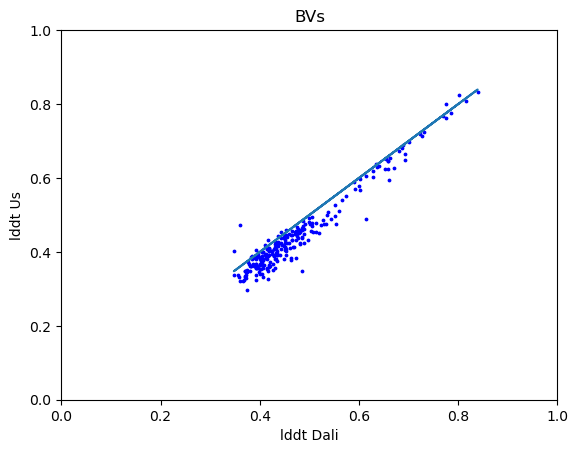

For Us: mean: 0.4442651131766197, std: 0.10652184946181323, sabaNum: 0.880995983935743
For Real: mean: 0.4725856267999703, std: 0.10061917786314
(30, 0.35, 10)


In [68]:
tMtx=genTMtx(blosumSingleCounts,blosumPairCounts)

#first find best scheme
goodScheme=pickBestScheme(pairList[0:100],valFileInfo)
lddtReal=[]
lddtUs=[]
for pair in pairList[0:250]:
    alnReal=makeRealAlnMtx_TM(pair[0],pair[1],valFileInfo)
    mult,shift,aff=goodScheme
    sim_mtx,lens=simMtxBV(pair,tMtx)
    alnMade=my_affine_sw_func(mult*(sim_mtx-shift), (lens[0][0],lens[0][1]), gap=-1,open=aff*(-1),temp=.001)
    lddtReal.append(detLDDT(pair[0],pair[1],alnReal))
    lddtUs.append(detLDDT(pair[0],pair[1],alnMade))
title="BVs"
plotLDDTs(lddtReal,lddtUs,title)
print(f"For Us: mean: {np.mean(lddtUs)}, std: {np.std(lddtUs)}, sabaNum: {sabaNumCalc(lddtReal,lddtUs)}")
print(f"For Real: mean: {np.mean(lddtReal)}, std: {np.std(lddtReal)}")
print(goodScheme)
